In [1]:
import torch
import os
from MaskRCNN import *
from MaskRCNN import maskrcnn_FF_fpn_v2_own_backbone, MaskRCNNPredictor
from FastRCNN import  FastRCNNPredictor
from dataset import CustomCocoDetection
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from tqdm import tqdm

/Users/benchen/.pyenv/versions/3.11.9/envs/bigdata/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the root directory for the COCO dataset
dataset_root = 'coco'
# Set the number of classes for the Mask R-CNN model (including background)
num_classes = 2  # Typically includes one background class and one object class
# Define the number of training epochs
epochs = 200
# Set the size of the input images for the model (images will be resized to this size)
img_size = 512
# Define the patience for early stopping; the model will stop training if no improvement is seen after this many epochs
Patience = 10
# Set whether to save the model only if early stopping is triggered
early_stop_only_save = False  # If True, only save the model when early stopping is applied
# Define the directory path where the trained model will be saved
model_save_path = "./"
# Set the name for the saved model file
name_model = 'mask'
# Specify the device for model training (e.g., 'cuda' for GPU or 'cpu' for CPU or 'mps' for Mac)
device = 'cuda'

In [3]:
# model save folder
folder_path = os.path.join(model_save_path, name_model)

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' has been created.")
else:
    print(f"Folder '{folder_path}' already exists.")
model_save_path = folder_path

Folder './mask' has been created.


In [4]:
# Load dataset
train_dataset = CustomCocoDetection(img_folder = dataset_root+'/train',
                                ann_file = dataset_root+'/annotations/train.json',
                                model = 'train'
                                )
val_dataset = CustomCocoDetection(img_folder = dataset_root+'/val',
                                ann_file = dataset_root + '/annotations/val.json',
                                )

train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [5]:
# Print sample data
import matplotlib.pyplot as plt
def visualize_sample(img, target):
    img = img.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(img)

    for box in target['boxes']:
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    masks = target['masks'].numpy()
    for mask in masks:
        ax.imshow(np.ma.masked_where(mask == 0, mask), cmap='jet', alpha=0.5)

    plt.show()

dataset = CustomCocoDetection(img_folder=dataset_root+'/train', ann_file=dataset_root+'/annotations/train.json', model='train')

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


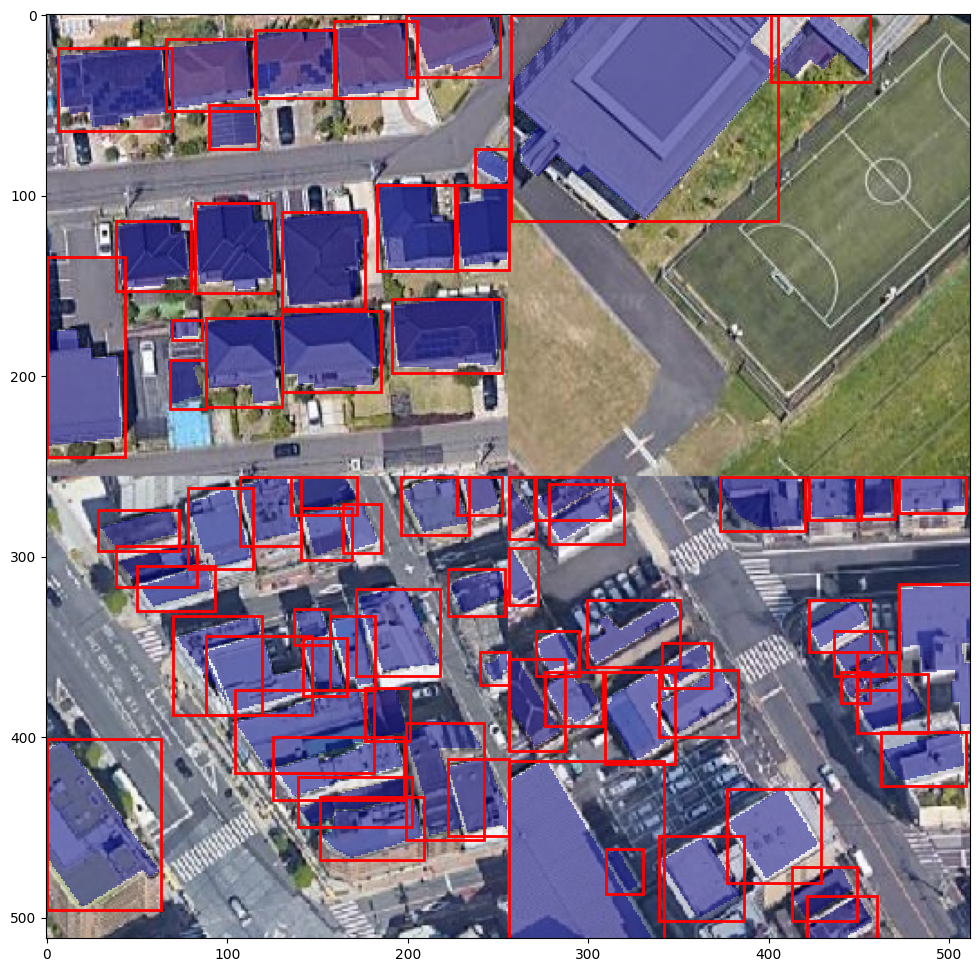

torch.Size([3, 512, 512])


In [6]:
import random
idx = random.randint(0, len(dataset))
img, target = dataset[idx]
visualize_sample(img, target)
print(img.shape)

In [7]:
# Define the Mask R-CNN model
model = maskrcnn_FF_fpn_v2_own_backbone(backbone_type = "convnext", version="convnext_base.fb_in22k_ft_in1k_384",num_classes=num_classes,min_size=[300,350,400,450,500,550,600],max_size=700,
                                              image_mean = [0.4807, 0.4841, 0.4823],
                                              image_std = [0.2165, 0.2045, 0.2040],
                                              rpn_pre_nms_top_n_train = 10000,
                                              rpn_pre_nms_top_n_test = 10000,
                                              rpn_post_nms_top_n_train = 7500,
                                              rpn_post_nms_top_n_test = 7500,
                                              rpn_nms_thresh =0.6,
                                              rpn_fg_iou_thresh = 0.6,
                                              rpn_bg_iou_thresh = 0.2,
                                              rpn_batch_size_per_image =3000,
                                              rpn_positive_fraction = 0.7,
                                              rpn_score_thresh = 0.0,
                                              box_score_thresh = 0.03,
                                              box_nms_thresh = 0.5,
                                              box_detections_per_img = 700,
                                              box_fg_iou_thresh = 0.6,
                                              box_bg_iou_thresh = 0.5,
                                              box_batch_size_per_image =3000,
                                              box_positive_fraction = 0.5,
                                              )


in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)


if device == 'mps':
    device = torch.device('mps')
elif device == 'cuda':
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.4807, 0.4841, 0.4823], std=[0.2165, 0.2045, 0.204])
      Resize(min_size=[300, 350, 400, 450, 500, 550, 600], max_size=700, mode='bilinear')
  )
  (backbone): Backbone(
    (own_backbone): ConvNeXtBackbone(
      (convnext): FeatureListNet(
        (stem_0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (stem_1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
        (stages_0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
              (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=128, out_features=512, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (norm): Identity()
    

In [8]:
# Define the EarlyStopping object
class EarlyStopping:
    def __init__(self, model_save_path ,name_model,only_save = False, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.model_save_path = model_save_path
        self.only_save = only_save
        self.lastloss = 0
        self.name_model = name_model

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
          if not self.only_save:
              self.counter += 1
              if self.verbose:
                  print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
              if self.counter >= self.patience:
                  self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({-self.best_score:.8f} --> {self.lastloss:.8f}).  Saving model ...')
        torch.save(model.state_dict(), self.model_save_path+"/"+self.name_model+".pt")  
        self.lastloss = val_loss


In [9]:
# Define the optimizer, learning rate scheduler, and early stopping
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)
main_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
early_stopping = EarlyStopping(patience = Patience, verbose=True, model_save_path = model_save_path, only_save = early_stop_only_save, name_model = name_model)

In [10]:
# Train the model
# Define the loss weights for the model
loss_weights = {
    'loss_classifier': 1.0,    
    'loss_box_reg': 1.0,       
    'loss_mask': 1.0,         
    'loss_objectness': 1.0,    
    'loss_rpn_box_reg': 1.0
}
# Train
for epoch in range(1, epochs + 1):
    model.train()
    progress_bar = tqdm(train_data_loader, desc=f"Epoch {epoch}/{epochs}")
    train_loss = 0.0
    for i, (images, targets) in enumerate(progress_bar):
        assert images is not None and len(images) > 0, "Images tensor is empty"
        assert targets is not None and len(targets) > 0, "Targets tensor is empty"


        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss_weights[key] * loss_dict[key] for key in loss_dict.keys())


        losses.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=losses.item())
        train_loss += losses.item()
    train_loss /= len(train_data_loader)

    val_loss = 0.0
    progress_bar_val = tqdm(val_data_loader, desc=f"Validation {epoch}/{epochs}")
    with torch.no_grad():
        for i, (images, targets) in enumerate(progress_bar_val):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss_weights[key] * loss_dict[key] for key in loss_dict.keys())

            val_loss += losses.item()
            progress_bar_val.set_postfix(val_loss=losses.item())

        val_loss /= len(val_data_loader)

    main_scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current learning rate: {current_lr}")

    early_stopping(val_loss, model)

    print(f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 1/200:   0%|          | 2/1892 [01:30<24:04:40, 45.86s/it, loss=2.65]